## Instructions

You are asked to complete the following files:
* **pruned_layers.py**, which contains the pruning of DNNs to reduce the storage of insignificant weight parameters by two methods: pruning by percentage and prune by standara deviation.
* **train_util.py**, which includes the training process of DNNs with pruned connections.
* **quantize.py**, which applies the quantization (weight sharing) part on the DNN to reduce the storage of weight parameters.
* **huffman_coding.py**, which applies the Huffman coding onto the weight of DNNs to further compress the weight size.

You are asked to submit the following files:
* **net_before_pruning.pt**, which is the weight parameters before applying pruning on DNN weight parameters.
* **net_after_pruning.pt**, which is the weight paramters after applying pruning on DNN weight parameters.
* **net_after_quantization.pt**, which is the weight parameters after applying quantization (weight sharing) on DNN weight parameters.
* **codebook_vgg16.npy**, which is the quantization codebook of each layer after applying quantization (weight sharing).
* **huffman_encoding.npy**, which is the encoding map of each item within the quantization codebook in the whole DNN architecture.
* **huffman_freq.npy**, which is the frequency map of each item within the quantization codebook in the whole DNN.

To ensure fair grading policy, we fix the choice of model to VGG16_half, which is a down-scaled version of VGG16 using a width multiplier of 0.5. You may check the implementation in **vgg16.py** for more details.

In [4]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
cd '/content/drive/MyDrive/CSC591-791-Lab2/'

/content/drive/MyDrive/CSC591-791-Lab2


In [6]:
from vgg16 import VGG16, VGG16_half
from train_util import train, finetune_after_prune, test
from quantize import quantize_whole_model
from huffman_coding import huffman_coding
from summary import summary
import torch
import numpy as np
from prune import prune

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Full-precision model training

In [7]:
net = VGG16_half()
net = net.to(device)

# Uncomment to load pretrained weights
net.load_state_dict(torch.load("net_before_pruning.pt"))

# Comment if you have loaded pretrained weights
# Tune the hyperparameters here.
#train(net, epochs=50, batch_size=128, lr=0.01, reg=0.005)

<All keys matched successfully>

In [8]:
# Load the best weight paramters
net.load_state_dict(torch.load("net_before_pruning.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.2860, Test accuracy=0.9145


0.9145

In [ ]:
print("-----Summary before pruning-----")
summary(net)
print("-------------------------------")

-----Summary before pruning-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		864			0.000000
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		9216			0.000000
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		18432			0.000000
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		36864			0.000000
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		73728			0.000000
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		147456			0.000000
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		147456			0.000000
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		294912			0.000000
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		589824			0.000000
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		589824			0.000000
29		Batch

### Pruning & Finetune with pruned connections

In [9]:
# Test accuracy before fine-tuning
prune(net, method='std', q=45.0, s=0.5)
test(net)

Files already downloaded and verified
Test Loss=0.3427, Test accuracy=0.8970


0.897

Files already downloaded and verified
Test Loss=0.2858, Test accuracy=0.9149
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		707			0.181713
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		7746			0.159505
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		16830			0.086914
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		33793			0.083306
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		67687			0.081936
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		135628			0.080214
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		135345			0.082133
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		269008			0.087836
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		535343			0.092368
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convo

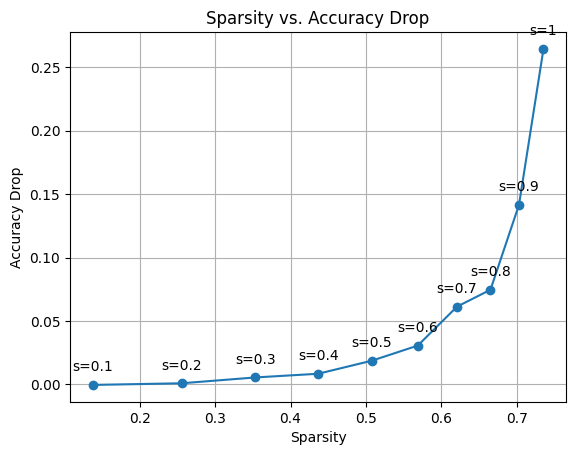

In [ ]:
# Question 2(D):

import matplotlib.pyplot as plt

sensitivity_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

sparsity_values = []
accuracy_drops = []

for s in sensitivity_values:
  prune(net, method='std', q=45.0, s=s)
  Test_accuracy = test(net)
  Sparsity = summary(net)
  accuracy_drop = 0.9145 - Test_accuracy



  sparsity_values.append(Sparsity)  # Assuming you store sparsity in 'sparsity'
  accuracy_drops.append(accuracy_drop)



# Plot the relationship between sparsity and accuracy drop
plt.plot(sparsity_values, accuracy_drops, marker='o', linestyle='-')
plt.xlabel('Sparsity')
plt.ylabel('Accuracy Drop')
plt.title('Sparsity vs. Accuracy Drop')
plt.grid(True)

for i, s in enumerate(sensitivity_values):
    plt.annotate(f's={s}', (sparsity_values[i], accuracy_drops[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()




In [10]:
# Uncomment to load pretrained weights
# net.load_state_dict(torch.load("net_after_pruning.pt"))
# Comment if you have loaded pretrained weights
finetune_after_prune(net, epochs=30, batch_size=128, lr=0.001, reg=0.00001)


==> Preparing data..
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified

Epoch: 0
[Step=16]	Loss=0.1634	acc=0.9585	570.9 examples/second
[Step=32]	Loss=0.1555	acc=0.9614	2443.7 examples/second
[Step=48]	Loss=0.1550	acc=0.9629	2534.6 examples/second
[Step=64]	Loss=0.1559	acc=0.9617	2517.8 examples/second
[Step=80]	Loss=0.1548	acc=0.9618	2498.4 examples/second
[Step=96]	Loss=0.1556	acc=0.9613	2510.3 examples/second
[Step=112]	Loss=0.1563	acc=0.9614	2569.9 examples/second
[Step=128]	Loss=0.1595	acc=0.9599	2051.9 examples/second
[Step=144]	Loss=0.1580	acc=0.9604	1510.2 examples/second
[Step=160]	Loss=0.1572	acc=0.9606	1704.0 examples/second
[Step=176]	Loss=0.1576	acc=0.9602	1821.9 examples/second
[Step=192]	Loss=0.1564	acc=0.9605	1492.9 examples/second
[Step=208]	Loss=0.1573	acc=0.9602	2159.8 examples/second
[Step=224]	Loss=0.1589	acc=0.9595	2596.0 examples/second
[Step=240]	Loss=0.1600	acc=0.9590	2440.8 examples/second
[Step=256]	Loss=0.1600	acc=0.9590	2530.6 examples/second
[Step=272]	Loss=0.1594	acc=0.9592	2596.8 exampl

In [13]:
# Load the best weight paramters
net.load_state_dict(torch.load("net_after_pruning.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3022, Test accuracy=0.9107


0.9107

In [14]:
print("-----Summary After pruning-----")
summary(net)
print("-------------------------------")

-----Summary After pruning-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		387			0.552083
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		4071			0.558268
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		10742			0.417209
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		22330			0.394260
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		44499			0.396444
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		90448			0.386610
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		88988			0.396512
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		173091			0.413076
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		335014			0.432010
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		319733			0.457918
29		BatchNor

In [15]:
# Test accuracy before fine-tuning
prune(net, method='std', q=45.0, s=0.75)
test(net)

Files already downloaded and verified
Test Loss=0.4453, Test accuracy=0.8740


0.874

In [16]:
# Uncomment to load pretrained weights
# net.load_state_dict(torch.load("net_after_pruning.pt"))
# Comment if you have loaded pretrained weights
finetune_after_prune(net, epochs=30, batch_size=128, lr=0.001, reg=0.00001)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=16]	Loss=0.2427	acc=0.9375	513.2 examples/second
[Step=32]	Loss=0.2360	acc=0.9385	1568.4 examples/second
[Step=48]	Loss=0.2350	acc=0.9395	1488.7 examples/second
[Step=64]	Loss=0.2342	acc=0.9386	2177.0 examples/second
[Step=80]	Loss=0.2357	acc=0.9380	2369.8 examples/second
[Step=96]	Loss=0.2338	acc=0.9388	2230.4 examples/second
[Step=112]	Loss=0.2334	acc=0.9385	2023.7 examples/second
[Step=128]	Loss=0.2314	acc=0.9392	2465.4 examples/second
[Step=144]	Loss=0.2307	acc=0.9387	2467.9 examples/second
[Step=160]	Loss=0.2311	acc=0.9380	2398.8 examples/second
[Step=176]	Loss=0.2314	acc=0.9379	2412.9 examples/second
[Step=192]	Loss=0.2297	acc=0.9386	2426.6 examples/second
[Step=208]	Loss=0.2295	acc=0.9391	2518.4 examples/second
[Step=224]	Loss=0.2296	acc=0.9388	2403.6 examples/second
[Step=240]	Loss=0.2312	acc=0.9382	2166.3 examples/second
[Step=256]	Loss=0.2305	acc=0.9382	1485.4 exam

In [17]:
# Load the best weight paramters
net.load_state_dict(torch.load("net_after_pruning.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3601, Test accuracy=0.8965


0.8965

In [18]:
print("-----Summary After pruning-----")
summary(net)
print("-------------------------------")

-----Summary After pruning-----
Layer id	Type		Parameter	Non-zero parameter	Sparsity(\%)
1		Convolutional	864		285			0.670139
2		BatchNorm	N/A		N/A			N/A
3		ReLU		N/A		N/A			N/A
4		Convolutional	9216		2808			0.695312
5		BatchNorm	N/A		N/A			N/A
6		ReLU		N/A		N/A			N/A
7		Convolutional	18432		7769			0.578505
8		BatchNorm	N/A		N/A			N/A
9		ReLU		N/A		N/A			N/A
10		Convolutional	36864		16535			0.551459
11		BatchNorm	N/A		N/A			N/A
12		ReLU		N/A		N/A			N/A
13		Convolutional	73728		32792			0.555230
14		BatchNorm	N/A		N/A			N/A
15		ReLU		N/A		N/A			N/A
16		Convolutional	147456		67257			0.543884
17		BatchNorm	N/A		N/A			N/A
18		ReLU		N/A		N/A			N/A
19		Convolutional	147456		65234			0.557604
20		BatchNorm	N/A		N/A			N/A
21		ReLU		N/A		N/A			N/A
22		Convolutional	294912		125980			0.572822
23		BatchNorm	N/A		N/A			N/A
24		ReLU		N/A		N/A			N/A
25		Convolutional	589824		241013			0.591381
26		BatchNorm	N/A		N/A			N/A
27		ReLU		N/A		N/A			N/A
28		Convolutional	589824		226682			0.615679
29		BatchNorm

### Quantization

In [19]:
centers = quantize_whole_model(net, bits=4)
np.save("codebook_vgg16.npy", centers)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 1 layers quantization...
Complete 2 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 3 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 4 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 5 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 6 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 7 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 8 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 9 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 10 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 11 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 12 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 13 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 14 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Complete 15 layers quantization...
Complete 16 layers quantization...


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
test(net)

Files already downloaded and verified
Test Loss=0.3661, Test accuracy=0.8953


0.8953

### Huffman Coding

In [21]:
frequency_map, encoding_map = huffman_coding(net, centers)
np.save("huffman_encoding", encoding_map)
np.save("huffman_freq", frequency_map)

Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.1632 bits
Complete 1 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.0311 bits
Complete 2 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.4616 bits
Complete 3 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.5796 bits
Complete 4 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.5814 bits
Complete 5 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Average storage for each parameter after Huffman Coding: 2.6188 bits
Complete 6 layers for Huffman Coding...
Original storage for each parameter: 4.0000 bits
Ave

In [22]:
# Initialize variables to store the total weighted storage and total parameters
total_weighted_storage = 0.0
total_parameters = 0

# Iterate through layers in your network
for i, (frequencies, encodings) in enumerate(zip(frequency_map, encoding_map), start=1):
    layer_name = str(i)  # You may use the layer index as the name

    # Calculate the weighted sum for the current layer
    weighted_storage_for_layer = sum(frequencies[key] * len(encodings[key]) for key in encodings)

    # Add the weighted storage to the total
    total_weighted_storage += weighted_storage_for_layer

    # Add the total parameters for the current layer to the overall total
    total_parameters += sum(frequencies.values())

# Calculate the weighted average storage for the entire network
weighted_average = total_weighted_storage / total_parameters

print("Weighted Average Storage: %.2f" %weighted_average)

Weighted Average Storage: 2.20


In [23]:
test(net)

Files already downloaded and verified
Test Loss=0.3661, Test accuracy=0.8953


0.8953